In [13]:
import numpy as np
import pandas as pd
from utils.data import load_tc_data
from utils.plot import make_cmap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import seaborn as sns
import cartopy.feature as cfeature
from utils.evaluation import accumulated_rain
import warnings
import xesmf as xe
import warnings

# However, there is a bias in the description of outer TC size by ERA5, with large TC sizes particularly being underestimated, as with previous reanalyses, although the degree of underestimation shows no straightforward relationship with the horizontal resolution of reanalysis.
# https://www.sciencedirect.com/science/article/pii/S016980952031276X

# TODO: be sure about what's going on with inverted lats
# TODO: why are there blank images still?
# TODO: may need to look at generate_predictins_2 script to make sure the correct images are flipped

# If you have/make the file ~/.ssh/config, you can define settings to ssh from local to a BP node e.g.:
# Host bluepebble
# User yourusername
# Hostname bp1-login.acrc.bris.ac.uk
# PreferredAuthentications publickey
# ProxyCommand ssh yourusername@seis.bris.ac.uk nc %h %p

# Host bluepebble1
# User yourusername
# Hostname bp1-login01.acrc.bris.ac.uk
# PreferredAuthentications publickey
# ProxyCommand ssh yourusername@seis.bris.ac.uk nc %h %p
# Then start a notebook and make a local connection with something like:
# PORT=1234
# ssh -f -N -L 8080:localhost:$PORT bluepebble1
# ssh bluepebble1 "module load lang/python/anaconda; jupyter notebook --no-browser --port=$PORT"
# (choose a number that's likely to be unique to you for PORT. You can also insert a command to activate a given conda env after the model load part)

In [14]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',limit=1,cmap='Blues',title=False,levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None,ax=None,mask_oceans=False,cbar=False,cax=False):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<limit,np.nan,data)
        lon2d,lat2d = np.meshgrid(lons,lats)
        if plot != 'ax':
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                                colour='black'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                                colour='black'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                                colour='black'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                                colour='black'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                                colour='black'
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                                colour='black'
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)
        ax.outline_patch.set_linewidth(0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        if plot != 'ax':
                cbar = plt.colorbar(c, shrink=0.78)
                # cbar.outline.set_linewidth(0.5)
                cbar.ax.tick_params(labelsize=6,width=0.5)
        
        if cbar == True:
                precip_cmap,precip_norm = make_cmap(high_vals=True)
                # cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,norm=precip_norm,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                # cbar.ax.tick_params(labelsize=8,width=0.5)
                cbar.ax.tick_params(labelsize=18)

        if title != False:
                ax.set_title(title,fontsize=22)

        if plot=='show':
                plt.show()
        elif plot=='save':
                plt.savefig('accumulated_rainfall.png',bbox_inches='tight',dpi=300)
        else:
                return ax

In [15]:
# era5,era5_real,era5_input,era5_meta,mswep,mswep_real,mswep_input,mswep_meta = load_tc_data(set='extreme_valid',results='era5')
era5,era5_real,era5_input,era5_meta = load_tc_data(set='validation',results='era5')
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_ensemble_vaegan,pred_ensemble_gan,meta = load_tc_data(set='validation',results='test')

In [16]:
precip_cmap,precip_norm = make_cmap()


In [17]:
def mean2d(array):
	return np.mean(np.mean(array,axis=1),axis=1)

def peak2d(array):
	return np.max(np.max(array,axis=1),axis=1)

mswep_real_2 = mean2d(real)
era5_real_2 = mean2d(era5_real)
mswep_2 = mean2d(pred_ensemble_gan[:,:,:,0])
era5_2 = mean2d(era5[:,:,:,0])
mswep_input_2 = mean2d(inputs)
era5_input_2 = mean2d(era5_input[:,:,:,0])

mswep_real_3 = peak2d(real)
era5_real_3 = peak2d(era5_real)
mswep_3 = peak2d(pred_ensemble_gan[:,:,:,0])
era5_3 = peak2d(era5[:,:,:,0])
mswep_input_3 = peak2d(inputs)
era5_input_3 = peak2d(era5_input[:,:,:,0])

In [18]:
data = np.load('/user/home/al18709/work/tc_data_era5_flipped/train_X.npy')
print(data.shape)

(56822, 40, 40)


In [19]:
era5,era5_real,era5_input,era5_meta = load_tc_data(set='validation',results='era5')
era5_corrected,era5_real,era5_input_corrected,era5_meta = load_tc_data(set='validation',results='era5_corrected')

In [20]:
# for filtering correct timestamps
print(list)
a = np.array(pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2019236N10314.csv')['centre_lat'])
b = np.array(pd.read_csv('/user/work/al18709/tc_data_era5_flipped_10/meta_2019236N10314.csv')['centre_lat'])
intersection = np.where(np.in1d(b, a))[0]

thing = np.arange(0,120,1)
print(thing[intersection])

<class 'list'>
[  0   1   3   4   5   6   7   9  12  13  14  15  16  19  20  21  24  25
  26  27  28  29  30  31  32  34  35  36  37  38  39  40  41  42  43  44
  45  46  48  49  50  52  53  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  89  91  93  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113]


In [39]:
warnings.filterwarnings("ignore")
# j=range(40,42)
# dorian
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
meta_dorian = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2019236N10314.csv')
dorian_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2019236N10314.npy')[:,:,:,0]
dorian_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2019236N10314.npy')[:,:,:,0]
dorian_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2019236N10314.npy')[:,:,:,0]
sid_2019236N10314 = np.arange(len(dorian_real[:,0,0]))
# sid_2019236N10314 = j
accumulated_dorian,accumulated_dorian_pred = accumulated_rain(sid_2019236N10314,meta_dorian,dorian_real,dorian_pred,dorian_inputs)

# generate era5 dorian
dorian_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_pred-opt_5_normal_problem.npy')[:,:,:,0][intersection]
dorian_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_input-opt_5_normal_problem.npy')[:,:,:,0][intersection]
accumulated_dorian_era5,accumulated_dorian_era5_pred = accumulated_rain(sid_2019236N10314,meta_dorian,dorian_real,dorian_pred,dorian_inputs,era5=True)

# generate era5_corrected dorian
dorian_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_corrected_pred-opt_5_normal_problem.npy')[:,:,:,0][intersection]
dorian_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_corrected_input-opt_5_normal_problem.npy')[:,:,:,0][intersection]
accumulated_dorian_era5_corrected,accumulated_dorian_era5_pred_corrected = accumulated_rain(sid_2019236N10314,meta_dorian,dorian_real,dorian_pred,dorian_inputs,era5=True)
storm = '2019236N10314'

# get tracks
centre_lats_dorian = tracks['lat'].loc[tracks['sid']==storm].reset_index(drop=True)
centre_lons_dorian = tracks['lon'].loc[tracks['sid']==storm].reset_index(drop=True)
intensity_dorian = tracks['sshs'].loc[tracks['sid']==storm].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1097
lat upper:  1214
lon lower:  978
lon upper:  1146
lats:  (117,)
lons:  (168,)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1097
lat upper:  1214
lon lower:  978
lon upper:  1146
lats:  (117,)
lons:  (168,)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1097
lat upper:  1214
lon lower:  978
lon upper:  1146
lats:  (117,)
lons:  (168,)


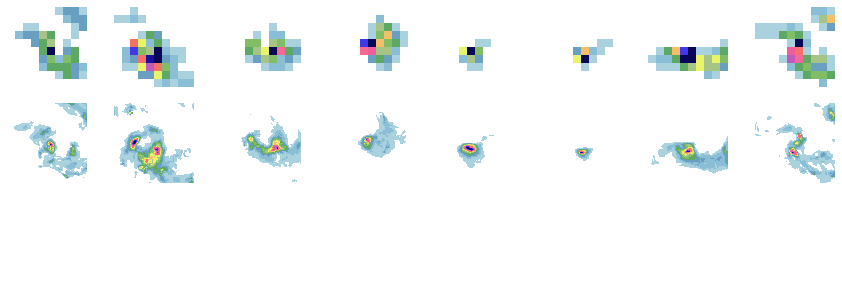

In [22]:
i = 100

gridspec = {'width_ratios': [1,1, 0.2]}
fig, axes = plt.subplots(3, 8, figsize=(15, 5))

storms = np.arange(0,200,10)
storm = 80
# for i in range(3):
for j in range(8):
	storm = storm + 1
	axes[0,j].axis('off')
	axes[1,j].axis('off')
	axes[2,j].axis('off')
	axes[0,j].imshow(era5_input_corrected[storm],cmap=precip_cmap)
	axes[1,j].imshow(era5_corrected[storm,:,:,0],cmap=precip_cmap)
	axes[2,j].imshow(era5_real[storm],cmap=precip_cmap)

In [23]:
from scipy.stats import boxcox
print(era5_input.shape)
era5_input[era5_input <= 0] = 0.0000000000001
print(era5_input.shape)
y,fitted_lambda= boxcox(era5_input.flatten(),lmbda=None)
print(y.shape)

(17758, 10, 10, 1)
(17758, 10, 10, 1)
(1775800,)


In [24]:
print(y.shape)
era5_corrected_input = y.reshape(17758, 10, 10, 1)
era5_corrected_input_2 = mean2d(era5_corrected_input[:,:,:,0])
era5_corrected_2 = mean2d(era5_corrected[:,:,:,0])

era5_corrected_input_norm = (era5_input.flatten() / np.sum(era5_input)) * np.sum(inputs)
era5_corrected_input_norm = era5_corrected_input_norm.reshape(17758, 10, 10, 1)
era5_corrected_input_norm_2 = mean2d(era5_corrected_input_norm[:,:,:,0])

print(era5_corrected_input.shape)
print(era5_corrected_input_norm.shape)
np.save('/user/home/al18709/work/tc_data_era5_flipped_10/valid_corrected_X.npy',era5_corrected_input_norm)
test = np.load('/user/home/al18709/work/tc_data_era5_flipped_10/valid_corrected_X.npy')
print(test.shape)

array = np.load('/user/work/al18709/tc_data_era5_flipped_10/X_2019236N10314.npy')
array_mswep = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/X_2019236N10314.npy')
print(array.shape)
dorian_era5_norm = (array.flatten() / np.sum(array)) * np.sum(array_mswep)
dorian_era5_norm = dorian_era5_norm.reshape(array.shape)
np.save('/user/work/al18709/tc_data_era5_flipped_10/X_2019236N10314_corrected.npy',dorian_era5_norm)



(1775800,)
(17758, 10, 10, 1)
(17758, 10, 10, 1)
(17758, 10, 10, 1)
(114, 10, 10)


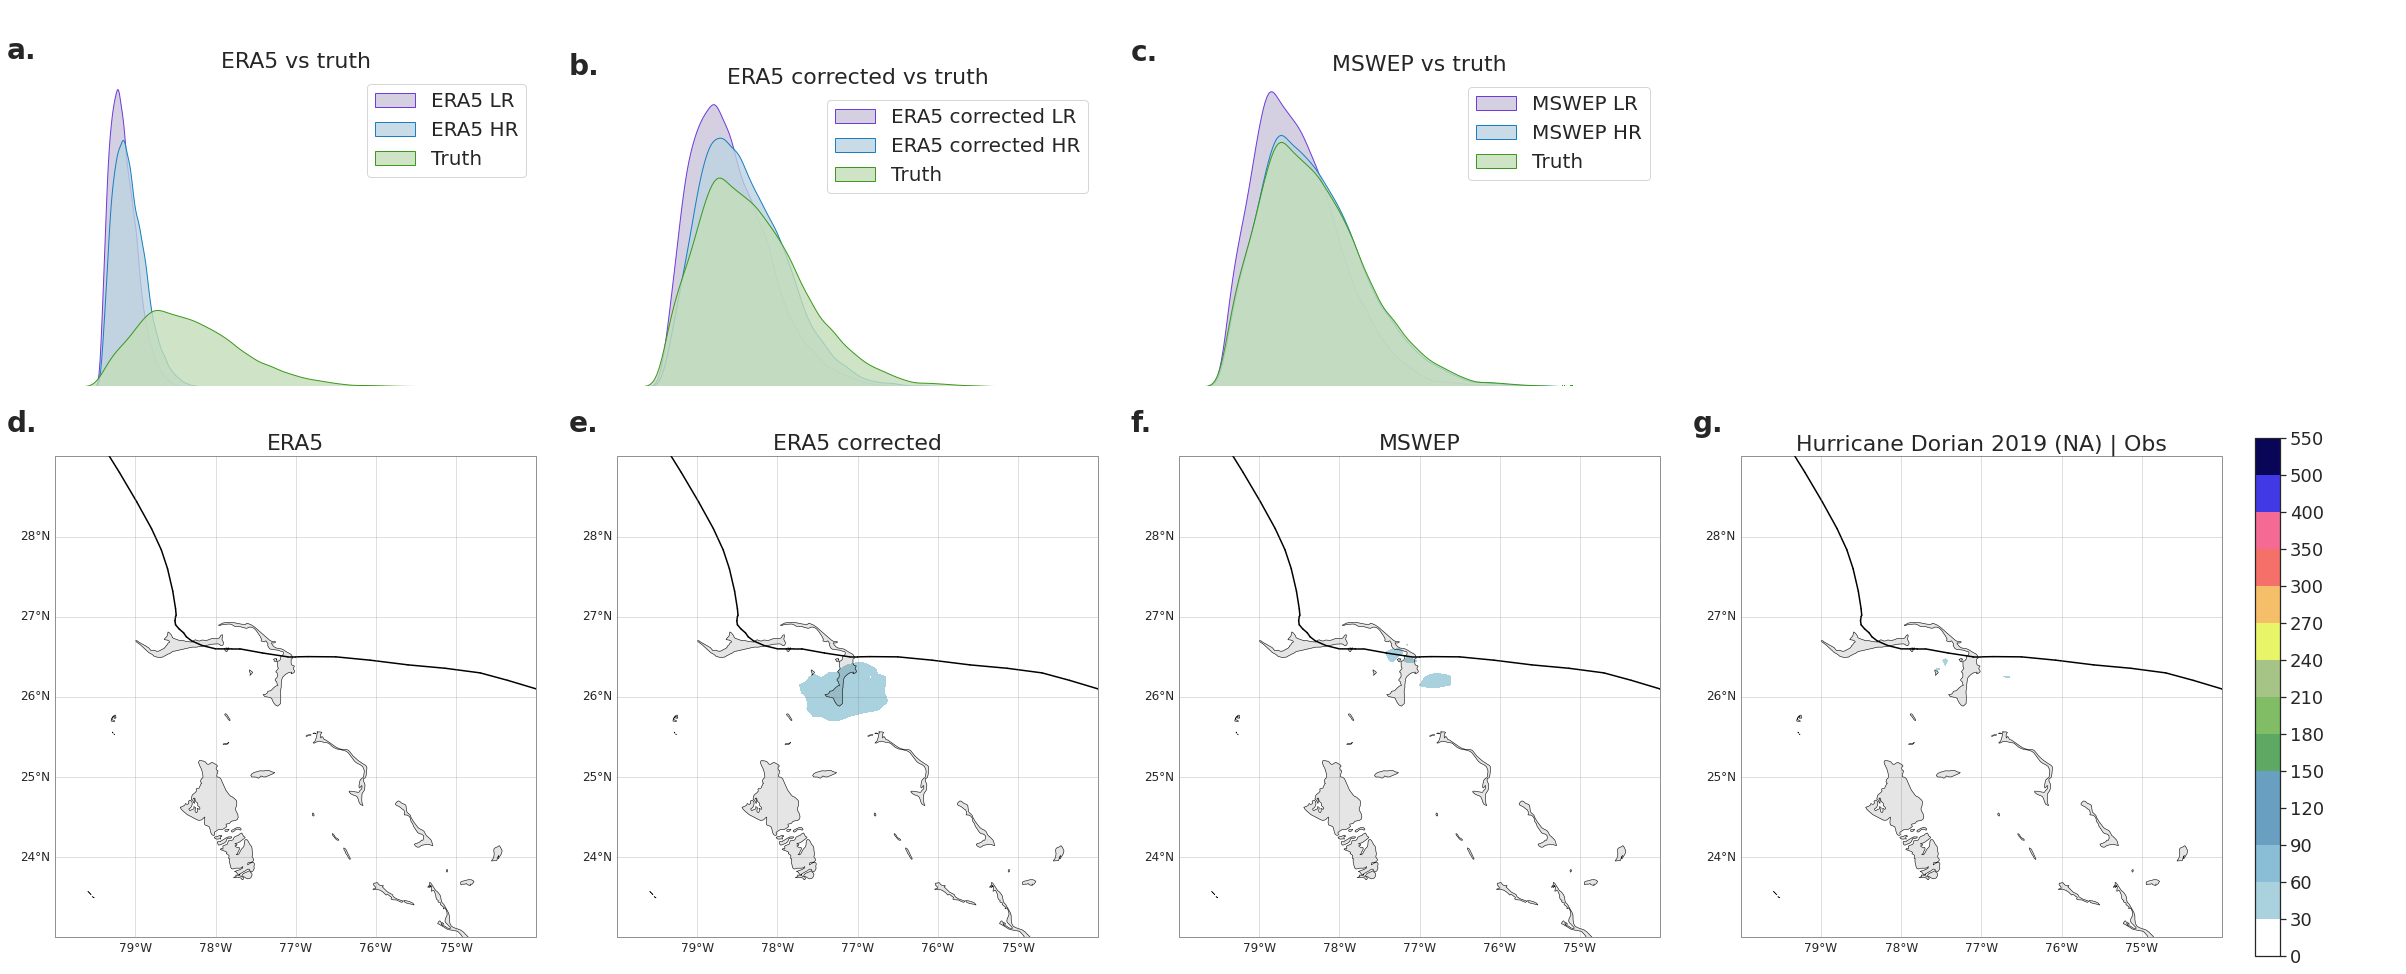

In [57]:


from torch import alpha_dropout_


sns.set_context("notebook")
gridspec = {'width_ratios': [1,1,1,1,0.2]}
fig, axes = plt.subplots(2, 5, figsize=(42, 20), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
axes[0, 4].axis('off')
axes[1, 4].axis('off')
axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[0, 2].axis('off')
axes[0, 3].axis('off')
# axes[2, 4].axis('off')
# axes[3, 5].axis('off')
# axes[0, 1].axis('off')
# axes[1, 1].axis('off')
# axes[2, 1].axis('off')
# axes[3, 2].axis('off')

# dorian
xlim_1 = (-80,-74)
ylim_1 = (23,29)
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 350, 400, 500,550]
# levels = [0,1,2,3,5,10,15,20,30,60]
vmax=550
# vmax = 60
# levels = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
sns.set_style("white")

title = 'ERA5'
axes[1,0] = plot_accumulated(accumulated_dorian_era5_pred['precipitation'],accumulated_dorian_era5_pred['lat'].values,accumulated_dorian_era5_pred['lon'].values,
							vmin=0,vmax=vmax,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_dorian,centre_lons=centre_lons_dorian,
							intensity=intensity_dorian,ax=axes[1,0],mask_oceans=True,title=title)
axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=28, weight='bold')

title = 'ERA5 corrected'
axes[1,1] = plot_accumulated(accumulated_dorian_era5_pred_corrected['precipitation'],accumulated_dorian_era5_pred_corrected['lat'].values,accumulated_dorian_era5_pred_corrected['lon'].values,
							vmin=0,vmax=vmax,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_dorian,centre_lons=centre_lons_dorian,
							intensity=intensity_dorian,ax=axes[1,1],mask_oceans=True,title=title)
axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=28, weight='bold')

title = 'MSWEP'
axes[1,2] = plot_accumulated(accumulated_dorian_pred['precipitation'],accumulated_dorian_pred['lat'].values,accumulated_dorian_pred['lon'].values,
							vmin=0,vmax=vmax,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_dorian,centre_lons=centre_lons_dorian,
							intensity=intensity_dorian,ax=axes[1,2],mask_oceans=True,title=title)
axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=28, weight='bold')

title = 'Hurricane Dorian 2019 (NA) | Obs'
axes[1,3] = plot_accumulated(accumulated_dorian['precipitation'],accumulated_dorian['lat'].values,accumulated_dorian['lon'].values,
							vmin=0,vmax=vmax,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_dorian,
							centre_lons=centre_lons_dorian,intensity=intensity_dorian,ax=axes[1,3],mask_oceans=True,title=title,cbar=True,cax=axes[1,4])
axes[1,3].text(-0.1, 1.05, 'g.', transform=axes[1,3].transAxes, size=28, weight='bold')


axes[1,0].set_xlim(xlim_1)
axes[1,0].set_ylim(ylim_1)
axes[1,1].set_xlim(xlim_1)
axes[1,1].set_ylim(ylim_1)
axes[1,2].set_xlim(xlim_1)
axes[1,2].set_ylim(ylim_1)
axes[1,3].set_xlim(xlim_1)
axes[1,3].set_ylim(ylim_1)


alpha=0.8
# first kde plot
sns.set_style("ticks")
sns.kdeplot(era5_input_2.flatten(),fill=True,color='#cbc3db',ax=axes[0,0],alpha=alpha,edgecolor='#6f3bdb')
sns.kdeplot(era5_2.flatten(),fill=True,color='#bcd3e0',ax=axes[0,0],alpha=alpha,edgecolor='#1780c2')
sns.kdeplot(mswep_real_2.flatten(),fill=True,color='#c3deba',ax=axes[0,0],alpha=alpha,edgecolor='#3b991c')
axes[0,0].legend(['ERA5 LR','ERA5 HR','Truth'],fontsize=20)
axes[0,0].set_title('ERA5 vs truth',fontsize=22)
axes[0,0].set_xlabel('Mean rainfall (mm / h)')
axes[0,0].set_aspect(7.5)
axes[0,0].set_anchor('S')
axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=28, weight='bold')

# second kde plot
sns.kdeplot(era5_corrected_input_norm_2.flatten(),fill=True,color='#cbc3db',ax=axes[0,1],alpha=alpha,edgecolor='#6f3bdb')
sns.kdeplot(era5_corrected_2.flatten(),fill=True,color='#bcd3e0',ax=axes[0,1],alpha=alpha,edgecolor='#1780c2')
sns.kdeplot(mswep_real_2.flatten(),fill=True,color='#c3deba',ax=axes[0,1],alpha=alpha,edgecolor='#3b991c')
axes[0,1].legend(['ERA5 corrected LR','ERA5 corrected HR','Truth'],fontsize=20)
axes[0,1].set_title('ERA5 corrected vs truth',fontsize=22)
axes[0,1].set_xlabel('Mean rainfall (mm / h)')
axes[0,1].set_aspect(20.5)
axes[0,1].set_anchor('S')
axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=28, weight='bold')

# third kde plot
sns.kdeplot(mswep_input_2.flatten(),fill=True,color='#cbc3db',ax=axes[0,2],alpha=alpha,edgecolor='#6f3bdb')
sns.kdeplot(mswep_2.flatten(),fill=True,color='#bcd3e0',ax=axes[0,2],alpha=alpha,edgecolor='#1780c2')
sns.kdeplot(mswep_real_2.flatten(),fill=True,color='#c3deba',ax=axes[0,2],alpha=alpha,edgecolor='#3b991c')
axes[0,2].legend(['MSWEP LR','MSWEP HR','Truth'],fontsize=20)
axes[0,2].set_title('MSWEP vs truth',fontsize=22)
axes[0,2].set_xlabel('Mean rainfall (mm / h)')
axes[0,2].set_aspect(24)
axes[0,2].set_anchor('S')
axes[0,2].text(-0.1, 1.05, 'c.', transform=axes[0,2].transAxes, size=28, weight='bold')

plt.subplots_adjust(hspace=0.1)
plt.savefig('dorian.png',bbox_inches='tight')

In [26]:
#TODO: quickly just check that the same correction works worse for just bilinear interpolation
# N=and calculate the crps for Bilinear interp so don't have to show it

grid_out = xr.Dataset({'longitude': np.linspace(0, 100, 100),
				'latitude': np.linspace(-50, 50, 100)
				})

grid_in = xr.Dataset({'longitude': np.linspace(0, 100, 10),
					'latitude': np.linspace(-50, 50, 10)
				})

regridder = xe.Regridder(grid_in, grid_out, 'bilinear')

In [27]:

warnings.filterwarnings("ignore", category=FutureWarning)
print(era5_input.shape)
bilinear = regridder(era5_input[:,:,:,0])
print(bilinear.shape)

print(era5_input.shape)
bilinear_corrected = regridder(era5_input_corrected[:,:,:,0])
print(bilinear_corrected.shape)

bilinear_2 = mean2d(bilinear)
bilinear_corrected_2 = mean2d(bilinear_corrected)

# meta_dorian = pd.read_csv('/user/work/al18709/tc_data_era5_flipped_10/meta_2019236N10314.csv')
# dorian_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_corrected_pred-opt_5_normal_problem.npy')[:,:,:,0]
dorian_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_input-opt_5_normal_problem.npy')[:,:,:,0][intersection]
dorian_bilinear = regridder(dorian_inputs)
# dorian_bilinear = np.flip(dorian_bilinear,axis=1)
accumulated_dorian_era5,accumulated_dorian_era5_pred = accumulated_rain(sid_2019236N10314,meta_dorian,dorian_real,dorian_bilinear,dorian_inputs,era5=True)

dorian_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_corrected_input-opt_5_normal_problem.npy')[:,:,:,0][intersection]
dorian_bilinear_corrected = regridder(dorian_inputs)
# dorian_bilinear_corrected = np.flip(dorian_bilinear_corrected,axis=1)
accumulated_dorian_era5_corrected,accumulated_dorian_era5_pred_corrected = accumulated_rain(sid_2019236N10314,meta_dorian,dorian_real,dorian_bilinear_corrected,dorian_inputs,era5=True)

(17758, 10, 10, 1)
(17758, 100, 100)
(17758, 10, 10, 1)
(18000, 100, 100)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  956
lat upper:  1367
lon lower:  952
lon upper:  1362
lats:  (411,)
lons:  (410,)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  956
lat upper:  1367
lon lower:  952
lon upper:  1362
lats:  (411,)
lons:  (410,)


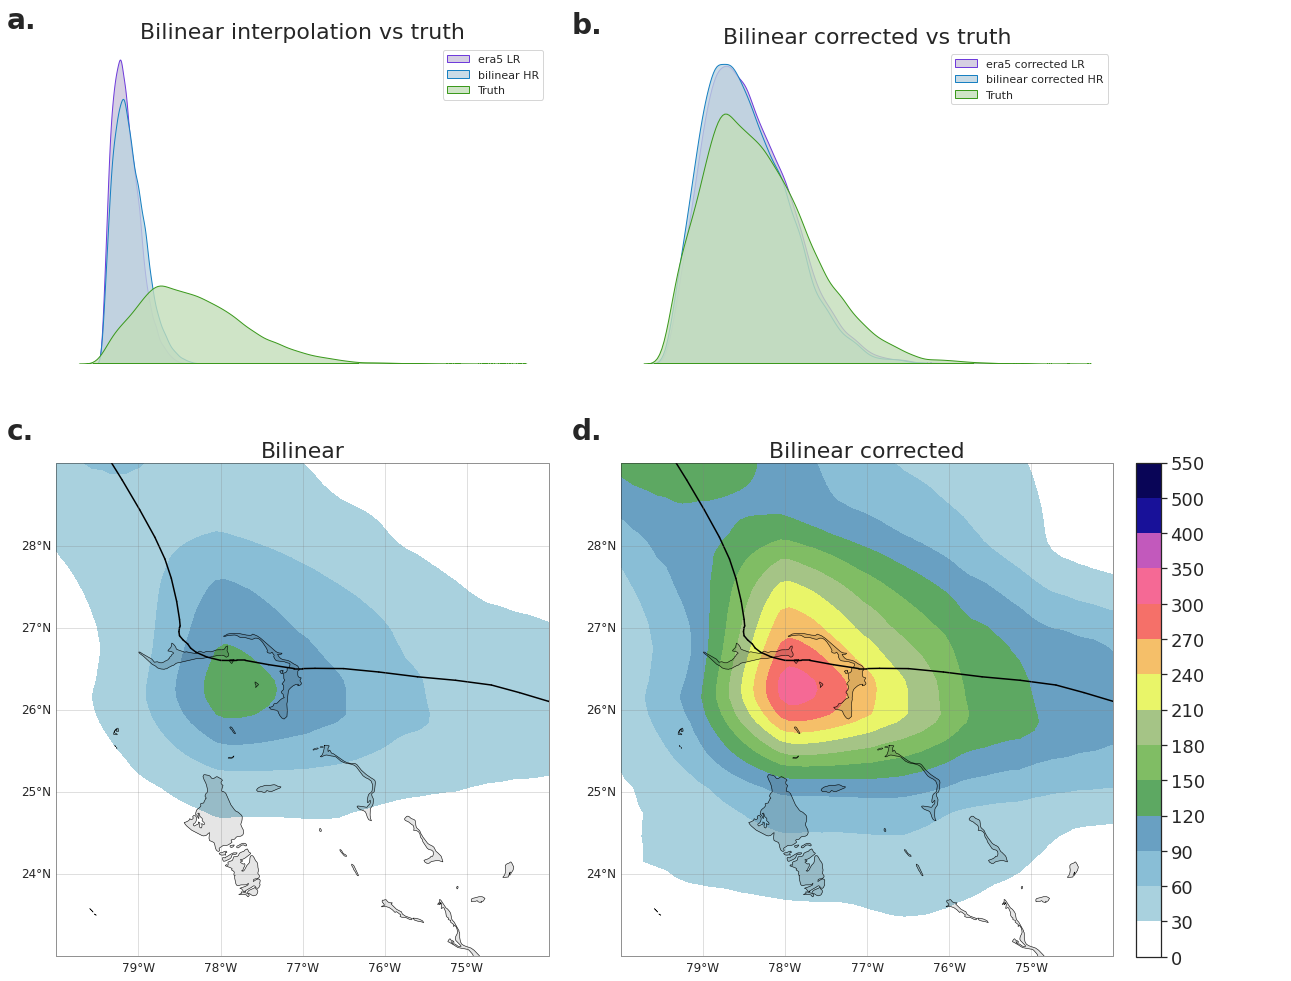

In [28]:
sns.set_context("notebook")
# sns.kdeplot(mswep_input_2.flatten(),fill=True,color='#cbc3db',ax=axes[0,2],alpha=alpha,edgecolor='#6f3bdb')
# sns.kdeplot(mswep_2.flatten(),fill=True,color='#bcd3e0',ax=axes[0,2],alpha=alpha,edgecolor='#1780c2')
# sns.kdeplot(mswep_real_2.flatten(),fill=True,color='#c3deba',ax=axes[0,2],alpha=alpha,edgecolor='#3b991c')


gridspec = {'width_ratios': [1,1,0.2]}
fig, axes = plt.subplots(2, 3, figsize=(22, 20), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
axes[0, 2].axis('off')
axes[1, 2].axis('off')
axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[0, 2].axis('off')
sns.set_style("ticks")

sns.kdeplot(era5_input_2.flatten(),fill=True,color='#cbc3db',ax=axes[0,0],alpha=alpha,edgecolor='#6f3bdb')
sns.kdeplot(bilinear_2.flatten(),fill=True,color='#bcd3e0',ax=axes[0,0],alpha=alpha,edgecolor='#1780c2')
sns.kdeplot(mswep_real_2.flatten(),fill=True,color='#c3deba',ax=axes[0,0],alpha=alpha,edgecolor='#3b991c')
axes[0,0].legend(['era5 LR','bilinear HR','Truth'])
axes[0,0].set_title('Bilinear interpolation vs truth',fontsize=22)
axes[0,0].set_xlabel('Mean rainfall (mm / h)')
axes[0,0].set_aspect(7.5)
axes[0,0].set_anchor('S')
axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=28, weight='bold')

sns.kdeplot(era5_corrected_2.flatten(),fill=True,color='#cbc3db',ax=axes[0,1],alpha=alpha,edgecolor='#6f3bdb')
sns.kdeplot(bilinear_corrected_2.flatten(),fill=True,color='#bcd3e0',ax=axes[0,1],alpha=alpha,edgecolor='#1780c2')
sns.set_style("ticks")
sns.kdeplot(mswep_real_2.flatten(),fill=True,color='#c3deba',ax=axes[0,1],alpha=alpha,edgecolor='#3b991c')
axes[0,1].legend(['era5 corrected LR','bilinear corrected HR','Truth'])
axes[0,1].set_title('Bilinear corrected vs truth',fontsize=22)
axes[0,1].set_xlabel('Mean rainfall (mm / h)')
axes[0,1].set_aspect(24)
axes[0,1].set_anchor('S')
axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=28, weight='bold')

axes[1,0].set_xlim(xlim_1)
axes[1,0].set_ylim(ylim_1)
axes[1,1].set_xlim(xlim_1)
axes[1,1].set_ylim(ylim_1)

title = 'Bilinear'
axes[1,0] = plot_accumulated(accumulated_dorian_era5_pred['precipitation'],accumulated_dorian_era5_pred['lat'].values,accumulated_dorian_era5_pred['lon'].values,
							vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_dorian,centre_lons=centre_lons_dorian,
							intensity=intensity_dorian,ax=axes[1,0],mask_oceans=True,title=title)
axes[1,0].text(-0.1, 1.05, 'c.', transform=axes[1,0].transAxes, size=28, weight='bold')

title = 'Bilinear corrected'
axes[1,1] = plot_accumulated(accumulated_dorian_era5_pred_corrected['precipitation'],accumulated_dorian_era5_pred_corrected['lat'].values,accumulated_dorian_era5_pred_corrected['lon'].values,
							vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_dorian,centre_lons=centre_lons_dorian,
							intensity=intensity_dorian,ax=axes[1,1],mask_oceans=True,title=title,cbar=True,cax=axes[1,2])
axes[1,1].text(-0.1, 1.05, 'd.', transform=axes[1,1].transAxes, size=28, weight='bold')


plt.savefig('bilinear.png',bbox_inches='tight')

In [29]:
print(accumulated_dorian_era5_pred['precipitation'].shape)

(411, 410)


In [30]:
print(dorian_pred.shape)

(97, 100, 100)


In [31]:
print(np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2019236N10314.npy')[:,:,:,0].shape)

(97, 100, 100)


In [32]:
a = list(pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2019236N10314.csv')['centre_lat'])
b = list(pd.read_csv('/user/work/al18709/tc_data_era5_flipped_10/meta_2019236N10314.csv')['centre_lat'])

In [33]:

print(len(intersection))
print(len(a))
print(b)

97
97
[10.8, 11.6, 13.0, 15.7, 19.2, 22.8, 25.3, 26.3, 26.6, 26.9, 28.1, 30.7, 33.4, 37.4, 11.2, 12.2, 14.2, 17.3, 21.0, 24.3, 25.9, 26.5, 26.7, 27.1, 29.5, 32.1, 35.1, 35.2, 40.8, 11.2998, 12.3924, 14.6596, 17.7077, 17.8, 21.5149, 24.5724, 26.0076, 26.503, 26.75, 27.32, 29.8074, 32.3996, 35.665, 41.7633, 10.6, 11.4, 12.6, 15.0, 18.4, 22.0, 24.8, 26.1, 26.5, 26.8, 27.6, 30.1, 32.7, 36.2, 10.6999, 11.4923, 12.7999, 15.3575, 18.8694, 22.4224, 25.0648, 26.2071, 26.5481, 26.85, 27.835, 30.3925, 33.0428, 36.7694, 10.8998, 11.7425, 13.219, 16.0349, 19.585, 23.1501, 25.465, 26.3575, 26.5987, 26.95, 28.435, 31.0424, 33.7271, 38.0966, 11.0, 11.9, 13.5, 16.4, 20.0, 23.5, 25.6, 26.4, 26.6, 27.0, 28.8, 31.4, 34.1, 38.9, 11.1, 12.0424, 13.7276, 16.8402, 20.485, 23.9148, 25.7572, 26.4585, 26.6406, 27.02, 29.1575, 31.7576, 34.5536, 39.8105]


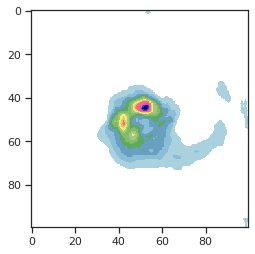

range(-50, 50)
(100, 100)
(100, 100)
(100, 100)


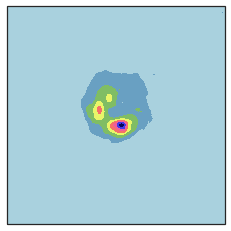

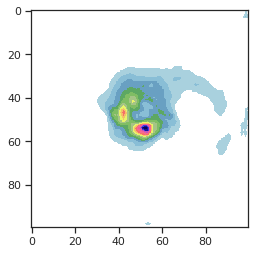

range(-50, 50)
(100, 100)
(100, 100)
(100, 100)


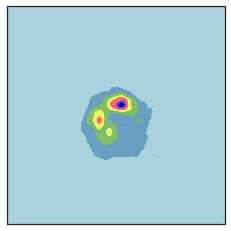

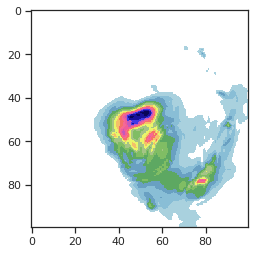

range(-50, 50)
(100, 100)
(100, 100)
(100, 100)


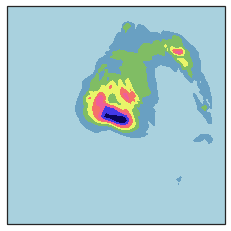

In [34]:

# proof that you don't want to flip era5 data
dorian_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_pred-opt_5_normal_problem.npy')[:,:,:,0][intersection]
i = 31
plt.imshow(dorian_pred[i],cmap=precip_cmap)
plt.show()
lats = range(-50,50)
lons = range(0,100)
print(lats)
lon2d,lat2d = np.meshgrid(lons,lats)
print(lon2d.shape)
print(lat2d.shape)
print(dorian_pred[i].shape)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(lon2d,lat2d,dorian_pred[i],cmap = precip_cmap, transform=ccrs.PlateCarree())
plt.show()


dorian_pred = np.flip(dorian_pred,axis=1)
plt.imshow(dorian_pred[i],cmap=precip_cmap)
plt.show()
lats = range(-50,50)
lons = range(0,100)
print(lats)
lon2d,lat2d = np.meshgrid(lons,lats)
print(lon2d.shape)
print(lat2d.shape)
print(dorian_pred[i].shape)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(lon2d,lat2d,dorian_pred[i],cmap = precip_cmap, transform=ccrs.PlateCarree())
plt.show()


dorian_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2019236N10314.npy')[:,:,:,0]
plt.imshow(dorian_pred[i],cmap=precip_cmap)
plt.show()

lats = range(-50,50)
lons = range(0,100)
print(lats)
lon2d,lat2d = np.meshgrid(lons,lats)
print(lon2d.shape)
print(lat2d.shape)
print(dorian_pred[i].shape)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(lon2d,lat2d,dorian_pred[i],cmap = precip_cmap, transform=ccrs.PlateCarree())
plt.show()

In [35]:
fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
from netCDF4 import Dataset
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
print('lat shape: ',lat)
print('lon shape: ',lon)

lat shape:  [-89.95001  -89.850006 -89.75     ...  89.75      89.85      89.95    ]
lon shape:  [-179.95    -179.84999 -179.75    ...  179.75002  179.85002  179.95   ]


In [36]:
fp = '/bp1store/geog-tropical/data/ERA-5/hour/precipitation_invertlat/ERA5_precipitation_3hrly_202112.nc'
from netCDF4 import Dataset
d = Dataset(fp, 'r')
lat = d.variables['latitude'][:] #lat
lon = d.variables['longitude'][:] #lon
print('lat shape: ',lat)
print('lon shape: ',lon)

lat shape:  [-90.   -89.75 -89.5  -89.25 -89.   -88.75 -88.5  -88.25 -88.   -87.75
 -87.5  -87.25 -87.   -86.75 -86.5  -86.25 -86.   -85.75 -85.5  -85.25
 -85.   -84.75 -84.5  -84.25 -84.   -83.75 -83.5  -83.25 -83.   -82.75
 -82.5  -82.25 -82.   -81.75 -81.5  -81.25 -81.   -80.75 -80.5  -80.25
 -80.   -79.75 -79.5  -79.25 -79.   -78.75 -78.5  -78.25 -78.   -77.75
 -77.5  -77.25 -77.   -76.75 -76.5  -76.25 -76.   -75.75 -75.5  -75.25
 -75.   -74.75 -74.5  -74.25 -74.   -73.75 -73.5  -73.25 -73.   -72.75
 -72.5  -72.25 -72.   -71.75 -71.5  -71.25 -71.   -70.75 -70.5  -70.25
 -70.   -69.75 -69.5  -69.25 -69.   -68.75 -68.5  -68.25 -68.   -67.75
 -67.5  -67.25 -67.   -66.75 -66.5  -66.25 -66.   -65.75 -65.5  -65.25
 -65.   -64.75 -64.5  -64.25 -64.   -63.75 -63.5  -63.25 -63.   -62.75
 -62.5  -62.25 -62.   -61.75 -61.5  -61.25 -61.   -60.75 -60.5  -60.25
 -60.   -59.75 -59.5  -59.25 -59.   -58.75 -58.5  -58.25 -58.   -57.75
 -57.5  -57.25 -57.   -56.75 -56.5  -56.25 -56.   -55.75 -55.5  -

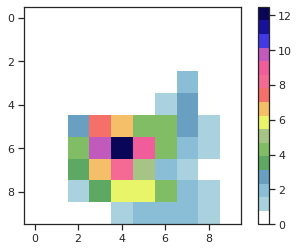

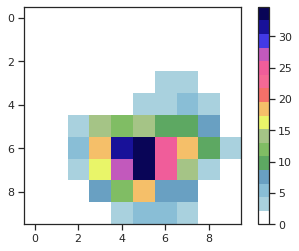

In [47]:
i = 96
dorian_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_era5_input-opt_5_normal_problem.npy')[:,:,:,0][intersection]
plt.imshow(dorian_inputs[i],cmap=precip_cmap)
plt.colorbar()
plt.show()
dorian_inputs_mswep = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2019236N10314.npy')[:,:,:,0]
plt.imshow(dorian_inputs_mswep[i],cmap=precip_cmap)
plt.colorbar()
plt.show()

In [38]:
print(np.sum(inputs)/np.sum(era5_input))

2.8787965936526714


In [53]:
era5_hourly = xr.load_dataset('/bp1store/geog-tropical/data/ERA-5/hour/precipitation_invertlat/ERA5_precipitation_3hrly_202107.nc')
era5_3hourly = xr.load_dataset('/bp1store/geog-tropical/data/ERA-5/hour/precipitation_invertlat_em/ERA5_precipitation_3hrly_202107.nc')

In [54]:
print(np.max(era5_hourly.tp.values))

65.647125


In [55]:
print(np.max(era5_3hourly.tp.values))

77.23999


In [56]:
# era5 1 hourly data was incorrect to use and compare to MSWEP 3 hourly data
# downloaded era5 3 hourly data which should have been accumuated over 3 hours
# now era5 data is still too low and I can't really explain it but that's whats happening
# aside from this there is a tracking issue with ERA5 and I'm trying to work out if it's me or ERA5 (I don't think its me because the method is exactly the same as mswep which works)
# so ERA5 isn't a great dataset to use?

In [ ]:

# according to 10.1175/JCLI-D-19-0999.1 ERA5 (hourly) and ERA-interim (3 hourly) underestimate rainfall in all bins, you can also see that era-interim is not 3x greater than era5 in fig2
# they also look at cross flow angle of wind, and i dont' know what this is so what is it? and is this related to the tracking issue?